# Pronósticos de Series de Tiempo
## Ejercicio Práctico Modelo Random Forest
### Semana 2 a semana 5


Parte I: Solución práctica de un problema de pronóstico a un activo financiero particular. Sigue estas indicaciones:

1. Descarga de Yahoo Finance la serie de precios de cierre del activo META en las fechas: 01-05-2016 al 28-01-2018.

2. Grafica la serie.

3. Prepara los datos a manera que cuentes con un formato adecuado para la fecha.

4. Parte la serie a un 5% de prueba y el restante para el entrenamiento.

5. Realiza el preprocesamiento necesario para aplicar cada uno de los modelos. En el caso de LSTM diseña y entrena la red con 200 nodos, la función de activación “relu”, epochs=30, función de perdida de ‘mse’, longitud de ventana de 10 yoptimizer='adam'.

6. Aplica cada uno de los modelos MARS, LSTM, RF y SSA a la serie de META. Te puedes apoyar en los tutoriales realizados durante estas semanas.

7. Empleando tus resultados, calcula las métricas para la medición de asertividad de un pronóstico, al menos debescalcular dos métricos de error de pronóstico, ejemplo: MAPE, RMSE, MAE, entre otros.

<a id="2"></a> <br>
### 1. Importación de librerías requeridas

Importa las siguientes librerías para desarrollar este tutorial:

In [5]:
pip install skforecast

Note: you may need to restart the kernel to use updated packages.


In [6]:
#Esta es requerida para importar los datos financieros
!pip install yfinance

^C
ERROR: Operation cancelled by user


In [7]:
# Manipulación datos
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
#Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
# warnings.filterwarnings('ignore')

In [8]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
##Si tienes problemas para descargar pandas datareader, puedes probar la siguiente línea:
#!pip install git+https://github.com/pydata/pandas-datareader.git

<a id="3"></a> <br>
### 2. Importación de datos financieros

Establecemos primeramente la fecha de inicio y fin, así como el activo o los activos de interés. En este ejemplo, emplearemos únicamente un activo, pero dejo desactivados otros ejemplos de stocks (stks), índices (idx), monedas (ccy) como ejemplos de otros activos.

In [10]:
#Establecemos las fechas de consulta:
start = '2016-05-01'
end = '2018-01-28'
META='META'


In [11]:
#Una vez declarado el ticker, pedimos a través de la función de pandas data reader (pdr), bajar lso datos de la fuente de yahoo finance.
META = pdr.get_data_yahoo("META", start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [12]:
META.head()

Date
2016-05-02    118.570000
2016-05-03    117.430000
2016-05-04    118.059998
2016-05-05    117.809998
2016-05-06    119.489998
Name: Close, dtype: float64

In [13]:
#Pasamos a data frame los datos
dt= pandas.DataFrame(META)
dt.head()

,Close
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998


In [14]:
#Identificamos la longitud de la serie
len(dt)

439

In [15]:
#Damos un vistazo a los datos
dt.head()
dt.tail()
data = dt.rename(columns={'Close': 'y'})
data

,y
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998
...,...
2018-01-22,185.369995
2018-01-23,189.350006
2018-01-24,186.550003


<a id="4"></a> <br>
### 3. Visualización de datos financieros

Para mirar la serie, debemos importar la librería de matplotlib.

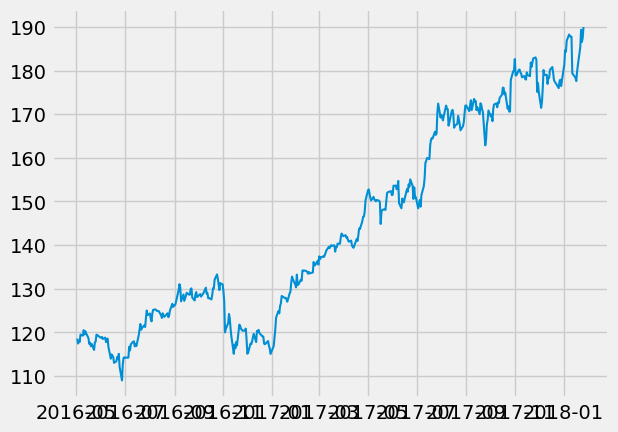

In [16]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.plot(dt)

<a id="5"></a> <br>
### 4. Preprocesamiento de datos

En esta parte, debemos primero convertir nuestros datos tipo dataframe a un objeto de pandas con fecha. Igualmente, la parte de valores de la serie, como el precio, lo pasamos a un tipo NumPy array que facilitará el procesamiento. 

In [17]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(data.index)
dataindex

DatetimeIndex(['2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-09', '2016-05-10', '2016-05-11',
               '2016-05-12', '2016-05-13',
               ...
               '2018-01-12', '2018-01-16', '2018-01-17', '2018-01-18',
               '2018-01-19', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26'],
              dtype='datetime64[ns]', name='Date', length=439, freq=None)

<a id="6"></a> <br>
### 5. Partición de datos en entrenamiento y prueba

En esta seción, partimos el conjunto de datos de pueba y de entrenamiento. 

In [18]:
#Especificamos primeramente el porcentje del corte.
split_percent = 0.95
split = int(split_percent*len(data))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
data_train = data[:split]
data_test  = data[split:]

date_train = dataindex[:split]
date_test = dataindex[split:]

In [19]:
#Vemos los datos para las fechas que nos sirven para las gráficas
date_train
#date_test  #Igualmente para visualizarlos

DatetimeIndex(['2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-09', '2016-05-10', '2016-05-11',
               '2016-05-12', '2016-05-13',
               ...
               '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22'],
              dtype='datetime64[ns]', name='Date', length=417, freq=None)

In [20]:
#Imprimimos la longitud de ambos conjuntos de datos:
print(len(data_train))
print(len(data_test))

417
22


<a id="7"></a> <br>
### 6. Visualización conjunto de entrenamiento y prueba

Ahora verificamos como quedo la partición de nuestra serie de tiempo.

In [21]:
#Graficamos la serie anterior, aunando el valor del pronóstico.
trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'test'
)

layout = go.Layout(
    title = "Amzn Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# Regresión con Random Forest

### Creación del Forecaster

En esta sección aplicamos la función de Forecast Aurtoregress para la creación de ventanas con ciertos retrazos al cual se aplica el modelo de Random Forest. En este caso, consideramos 10 retrazos que capturan la estructura de datos de la serie y generan un pronóstico a 10 días.

In [22]:
# Creamos y entrenamos el modelo de Random Forest con la función de estructura de datos generada a través de la función Forecaster, en este caso, creando ventanas de 10 días:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 10
                )

forecaster.fit(y=data_train['y'])

### Predicciones en conjunto de prueba


Verifiquemos el rendimiento del modelo entrenado en el conjunto de test o prueba.

In [25]:
# Pronóstico, en este caso elegimos una ventana de 36 días.
# ==============================================================================
steps = 22
predictions = forecaster.predict(steps=steps)
predictions.head(5)

10    177.867499
11    179.198599
12    179.597099
13    179.285500
14    179.460500
Name: pred, dtype: float64

In [26]:
# Determinamos el error de pronóstico:
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
RMSE = sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 37.31805111312889
Test error (rmse): 6.108850228408689


### Refinamiento de los hiperparámetros

In [27]:
# Cálculo de hiperparámetros por grid search
# ==============================================================================
steps = 22
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 # Este valor se reemplazará en la grilla
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [02:35<00:00, 77.86s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 28.264182741724852



In [28]:
# Visualizamos los resultados del grid search
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",28.264183,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",28.689390,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",28.778569,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",29.038844,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",33.901387,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",33.948791,10,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",33.991118,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",34.795420,5,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",39.785046,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",40.273376,3,500


### Aplicación modelo óptimo a serie completa

A partir de la salida anterior, se define max_depth =10, n_estimators =100

In [29]:
# Configuramos la función de pronóstico de forecaster con la mejor combinación obteida de hiperparámetros.
# ==============================================================================
### Aquí debe ir tu codigo, 
regressor = RandomForestRegressor(max_depth=10 , n_estimators=100 , random_state=123)
### Hasta aquí modificas

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data['y'])

In [30]:
# Podemos imprimir la importancia de los rezagos
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.439704
1,lag_2,0.107797
2,lag_3,0.181222
3,lag_4,0.059398
4,lag_5,0.146024
5,lag_6,0.039171
6,lag_7,0.017138
7,lag_8,0.003035
8,lag_9,0.005151
9,lag_10,0.001360


### Generación del pronóstico hacia adelante

In [31]:
# Pronóstico, en este caso elegimos una ventana de 10 días.
# ==============================================================================
steps = 10
predictions = forecaster.predict(steps=steps)
predictions.head(5)

10    185.321275
11    185.304319
12    185.678499
13    183.517198
14    181.428800
Name: pred, dtype: float64

In [33]:
## Generamos las fechas a dichos pronósticos mediante la función de pandas date_range:
fin = data_test.index.max()   #Partimos de la fecha máxima de la sección de prueba, hacia adelante.
fwd_dates = pd.date_range(fin, periods=10).tolist()
fwd_dates

[Timestamp('2018-01-26 00:00:00', freq='D'),
 Timestamp('2018-01-27 00:00:00', freq='D'),
 Timestamp('2018-01-28 00:00:00', freq='D'),
 Timestamp('2018-01-29 00:00:00', freq='D'),
 Timestamp('2018-01-30 00:00:00', freq='D'),
 Timestamp('2018-01-31 00:00:00', freq='D'),
 Timestamp('2018-02-01 00:00:00', freq='D'),
 Timestamp('2018-02-02 00:00:00', freq='D'),
 Timestamp('2018-02-03 00:00:00', freq='D'),
 Timestamp('2018-02-04 00:00:00', freq='D')]

In [36]:
len(predictions)

10

In [37]:
actual=data_test[:10]

In [39]:
# METRICAS
from sklearn.metrics import mean_squared_error
from math import sqrt

#calcular RMSE
RMSE=sqrt (mean_squared_error (actual, predictions))
print(RMSE)

from sklearn.metrics import mean_absolute_error
MAE=(mean_absolute_error (actual, predictions))
MAE

6.7527742860346045


6.275463484076283

### Visualización del pronóstico futuro

A continuación verás graficamente las tres series de tiempo (train, test y forecast). El gráfico es interactivo, amplia la zona donde están las series de test y forecast.

In [35]:
#Graficamos la serie anterior, aunando el valor del pronóstico.

trace3 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'Test'
)

trace4 = go.Scatter(
    x = fwd_dates,
    y = predictions,
    mode = 'lines',
    name = 'Pronóstico Futuro Random Forest'
)

trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Train'
    )

layout = go.Layout(
    title = "META Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace3, trace4], layout=layout)
fig.show()

*Elaborado por Rebeca Gamboa para el curso de Pronósticos, MIAD*